In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import time

In [ ]:
class AegisCloakingEngine:
    def __init__(self, target_pool_path=None):
        """
        Implementation of the Fawkes Image Cloaking System.
        
        Args:
            target_pool_path: Path to a directory containing images of other people. 
                              Used to find the 'most dissimilar'
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"--- Aegis Cloaking Engine Initialized on {self.device} ---")

        # 1. Feature Extractor
        # use ResNet50 as a standard robust proxy.
        resnet = models.resnet50(pretrained=True).to(self.device)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1]).eval()
        
        # Freeze gradients for the feature extractor
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        # 2. Preprocessing 
        self.preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        # Inverse transform for visualization/saving
        self.denormalize = transforms.Compose([
            transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], 
                                 std=[1/0.229, 1/0.224, 1/0.225]),
        ])

        self.target_pool_path = target_pool_path

    def load_image_as_tensor(self, path):
        """Loads image and normalizes it for the model."""
        img = Image.open(path).convert('RGB')
        return self.preprocess(img).unsqueeze(0).to(self.device)

    def select_optimal_target(self, user_features):
        """
        Step 1 : Choosing a Target Class
        Scans the target_pool directory to find the face 'most dissimilar' 
        to the user's face in feature space.
        """
        if not self.target_pool_path or not os.path.exists(self.target_pool_path):
            print("No target pool provided. Using random noise target (High Privacy).")
            return None

        print("Searching for optimal target identity...")
        max_dist = -1.0
        best_target_path = None
        
        valid_exts = ('.jpg', '.jpeg', '.png')
        for filename in os.listdir(self.target_pool_path):
            if not filename.lower().endswith(valid_exts):
                continue
                
            path = os.path.join(self.target_pool_path, filename)
            try:
                # Load candidate target
                t_tensor = self.load_image_as_tensor(path)
                with torch.no_grad():
                    t_features = self.feature_extractor(t_tensor)
                
                # Calculate L2 distance [cite: 258]
                dist = torch.dist(user_features, t_features).item()
                
                if dist > max_dist:
                    max_dist = dist
                    best_target_path = path
            except Exception as e:
                continue
        
        if best_target_path:
            print(f"Target Selected: {os.path.basename(best_target_path)} (Distance: {max_dist:.4f})")
        return best_target_path

    def generate_cloak(self, input_path, manual_target_path=None, iterations=1000, lr=0.005, epsilon=0.05):
        """
        Step 2: Computing Per-image Cloaks[cite: 259].
        
        Args:
            iterations: Paper suggests 1000 iterations.
            epsilon: Budget for pixel change (e.g. 0.03-0.07).
            
        Returns:
            BGR numpy array ready for cv2.imwrite.
        """
        # A. Load Original Image
        original_tensor = self.load_image_as_tensor(input_path)
        
        # B. Extract User Features
        with torch.no_grad():
            user_features = self.feature_extractor(original_tensor)

        # C. Determine Target Features
        target_path = manual_target_path
        
        # If no manual target, find the best one automatically
        if not target_path:
            target_path = self.select_optimal_target(user_features)
            
        if target_path:
            target_tensor = self.load_image_as_tensor(target_path)
            with torch.no_grad():
                target_features = self.feature_extractor(target_tensor)
        else:
            # Fallback: Random features if no target images available
            target_features = torch.randn_like(user_features)

        # D. Initialize Delta (The Cloak)
        # We optimize 'delta', not the image itself.
        delta = torch.zeros_like(original_tensor, requires_grad=True).to(self.device)
        
        # E. Setup Optimizer
        # Adam optimizer 
        optimizer = optim.Adam([delta], lr=lr)
        mse_loss = nn.MSELoss()

        print(f"Starting Cloaking Process ({iterations} iters)...")
        
        for i in range(iterations):
            optimizer.zero_grad()
            
            # 1. Apply Delta to Image
            # Clamp delta to epsilon immediately to ensure constraints during forward pass
            clamped_delta = torch.clamp(delta, -epsilon, epsilon)
            cloaked_input = original_tensor + clamped_delta
            
            # 2. Extract Features of Cloaked Image
            current_features = self.feature_extractor(cloaked_input)
            
            # 3. Loss: Minimize distance to TARGET features 
            # We want the face to look like the Target, not the User.
            loss = mse_loss(current_features, target_features)
            
            loss.backward()
            optimizer.step()
            
            # 4. Project Delta (Constraint)
            # Ensure delta stays within valid epsilon range after update
            with torch.no_grad():
                delta.data = torch.clamp(delta.data, -epsilon, epsilon)
            
            if i % 100 == 0:
                print(f"Step {i}/{iterations} | Loss: {loss.item():.6f}")

        # F. Generate Final Image
        with torch.no_grad():
            # Apply final optimized delta
            final_delta = torch.clamp(delta, -epsilon, epsilon)
            final_tensor = original_tensor + final_delta
            
            # Denormalize back to [0,1] range for saving
            # Remove batch dim -> (C, H, W)
            final_tensor = self.denormalize(final_tensor.squeeze(0)) 
            
            # Clamp to ensure valid image range [0, 1]
            final_tensor = torch.clamp(final_tensor, 0, 1)
            
            # Convert to Numpy (H, W, C)
            final_image = final_tensor.permute(1, 2, 0).cpu().numpy()
            
            # Convert RGB to BGR 
            final_image = (final_image * 255).astype(np.uint8)
            final_bgr = cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR)
            
            return final_bgr

    def save_image(self, image, filename, folder_path="assets/cloakedImage"):
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        
        full_path = os.path.join(folder_path, filename)
        cv2.imwrite(full_path, image)
        print(f"Saved: {full_path}")
        return full_path

In [19]:
TARGET_POOL = "assets/targets/"  
cloaker = AegisCloakingEngine(target_pool_path=TARGET_POOL)

--- Aegis Cloaking Engine Initialized on cpu ---


c:\Users\rishi\Desktop\Workspace\PROJECTS\Aegis\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rishi\Desktop\Workspace\PROJECTS\Aegis\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
input_img = "assets/samples/face5.jpg"
# reduce epsilon for removing graininess
# increase iterartion for more invisibility

cloaked_face= cloaker.generate_cloak(input_path=input_img,iterations=1000,lr=0.005,epsilon=0.05)


Searching for optimal target identity...
Target Selected: face2.jpg (Distance: 21.0983)
Starting Cloaking Process (1000 iters)...
Step 0/1000 | Loss: 0.217352
Step 100/1000 | Loss: 0.005866
Step 200/1000 | Loss: 0.003927
Step 300/1000 | Loss: 0.003187
Step 400/1000 | Loss: 0.002995
Step 500/1000 | Loss: 0.002524
Step 600/1000 | Loss: 0.002346
Step 700/1000 | Loss: 0.002302
Step 800/1000 | Loss: 0.002178
Step 900/1000 | Loss: 0.002011


In [21]:
cloaker.save_image(cloaked_face, f"cloakedImg{int(1e7*(time.time()-int(time.time())))}.png")

Saved: assets/cloakedImage\cloakedImg55778.png


'assets/cloakedImage\\cloakedImg55778.png'

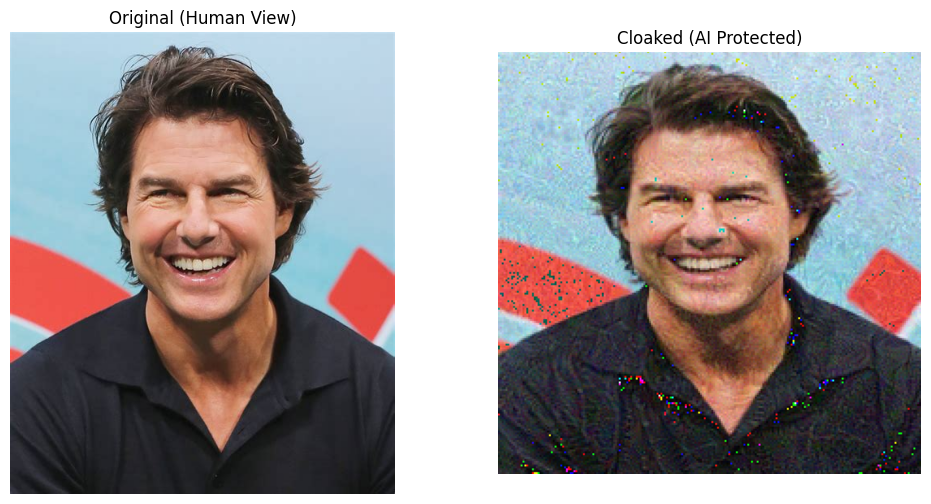

In [15]:
cloaker.show_comparison(input_img, cloaked_face)


In [9]:
cloaker.save_image(cloaked_face, f"cloakedImg{int(1e7*(time.time()-int(time.time())))}.png")

Successfully saved image to: assets/cloakedImage\cloakedImg9713222.png


'assets/cloakedImage\\cloakedImg9713222.png'

## Batch Processing

In [44]:
import glob

def process_folder(input_folder, target_path=None, output_folder="assets/cloakedImage"):
        """
        Scans a folder for images and cloaks every one of them.
        """
        extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.webp']
        image_files = []
        for ext in extensions:
            image_files.extend(glob.glob(os.path.join(input_folder, ext)))
        
        if not image_files:
            print(f"No images found in {input_folder}")
            return

        print(f"Found {len(image_files)} images. Starting batch cloaking...")
        
        for img_path in image_files:
            filename = os.path.basename(img_path)
            print(f"Processing: {filename}...")
            
            try:
                cloaked_img = cloaker.generate_cloak(img_path, target_path=target_path)
                cloaker.save_image(cloaked_img, f"cloaked_{filename}", output_folder)
            except Exception as e:
                print(f"Skipping {filename} due to error: {e}")


In [ ]:
process_folder(input_folder='assets/tomCruise',target_path="assets/samples/face1.jpg")

In [ ]:
# https://teachablemachine.withgoogle.com/models/OQSxfAz9x/